# Olist Cohort Analysis

В случае имеющихся данных классический retention-анализ по клиентам не применим, так как в преобразованной таблице с доставленными заказами отсутствуют повторные покупки. В связи с этим было принято решение выполнить когортный анализ заказов.

**Цель этапа** - проверить, является ли выявленная в ходе EDA зависимость между сроками доставки и оценками заказов стабильной во времени и не обусловленной отдельными периодами.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
orders_features = pd.read_csv('../data/orders_features.csv', sep=';')

In [3]:
df_delivered = orders_features[
    (orders_features['order_status'] == 'delivered') &
    (orders_features['delivery_days'].notna())
]

In [4]:
df_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,items_count,total_price,total_freight,max_payment_installments,total_payment_value,avg_review_score,reviews_count,delivery_days,total_amount_olist,has_review,is_late_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18 00:00:00,2017-10-10 21:25:13,1.0,29.99,8.72,1.0,38.71,4.0,1.0,8.0,38.71,1,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13 00:00:00,2018-08-07 15:27:45,1.0,118.70,22.76,1.0,141.46,4.0,1.0,14.0,141.46,1,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04 00:00:00,2018-08-17 18:06:29,1.0,159.90,19.22,3.0,179.12,5.0,1.0,9.0,179.12,1,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-15 00:00:00,2017-12-02 00:28:42,1.0,45.00,27.20,1.0,72.20,5.0,1.0,13.0,72.20,1,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-26 00:00:00,2018-02-16 18:17:02,1.0,19.90,8.72,1.0,28.62,5.0,1.0,3.0,28.62,1,0


In [5]:
# Извлекаем месяц заказа
df_delivered['order_purchase_timestamp'] = pd.to_datetime(df_delivered['order_purchase_timestamp'])
df_delivered['order_month'] = df_delivered['order_purchase_timestamp'].dt.to_period('M')

C:\Users\днс\AppData\Local\Temp\ipykernel_21288\798891797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delivered['order_purchase_timestamp'] = pd.to_datetime(df_delivered['order_purchase_timestamp'])
C:\Users\днс\AppData\Local\Temp\ipykernel_21288\798891797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delivered['order_month'] = df_delivered['order_purchase_timestamp'].dt.to_period('M')


## Когортный анализ опоздания доставок

In [23]:
#Доля заказов с опозданием доставки
late_by_month =df_delivered.groupby('order_month',as_index=False).agg({'is_late_delivery':'mean'}).sort_values("order_month")

In [19]:
late_by_month

,order_month,is_late_delivery
0,2016-09,1.000000
1,2016-10,0.011321
2,2016-12,0.000000
3,2017-01,0.030667
4,2017-02,0.032063
5,2017-03,0.055774
6,2017-04,0.078593
7,2017-05,0.036107
8,2017-06,0.038596
9,2017-07,0.034349


In [24]:
late_by_month["is_late_delivery"] *= 100
late_by_month["order_month"] = late_by_month["order_month"].dt.to_timestamp()

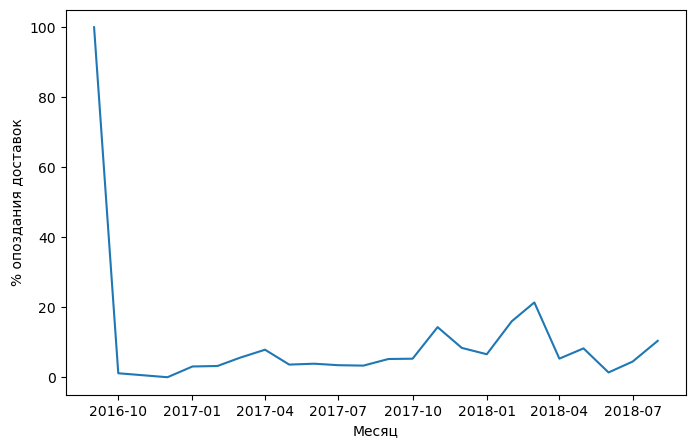

In [28]:
plt.figure(figsize=(8, 5))

sns.lineplot(
    data=late_by_month,
    x="order_month",
    y="is_late_delivery"
)

plt.ylabel("% опоздания доставок")
plt.xlabel("Месяц")
plt.show()

Когортный анализ доли заказов с опозданием доставки показывает, что в октябре 2016 года наблюдается экстремальное значение, когда доля опоздавших заказов достигает 100%.

С учётом сравнительно небольшого объёма заказов в данном месяце, данный всплеск, вероятно, является следствием единичного сбоя либо особенностей данных, а не устойчивой закономерностью.

В последующие месяцы динамика доли заказов с опозданием доставки остается относительно стабильной, без резких скачков, что свидетельствует об отсутствии выраженной сезонности и подтверждает устойчивость показателя во времени.

## Когортный анализ оценок

In [33]:
rating_by_month = df_delivered.query('has_review == 1').groupby('order_month',as_index=False).agg({'avg_review_score': 'mean'})

In [34]:
rating_by_month["order_month"] = rating_by_month["order_month"].dt.to_timestamp()

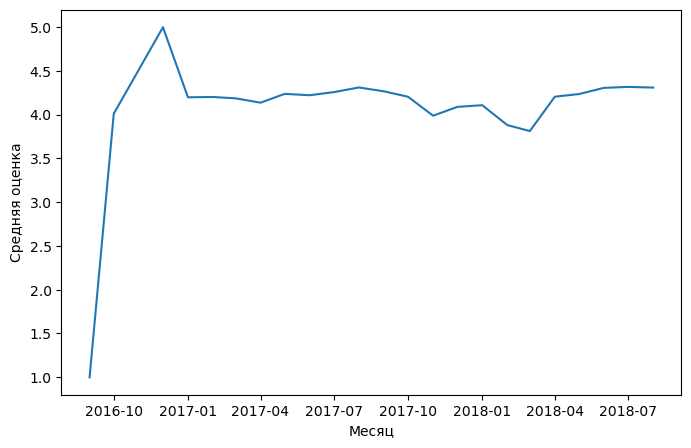

In [36]:
plt.figure(figsize=(8, 5))

sns.lineplot(
    data=rating_by_month,
    x="order_month",
    y="avg_review_score"
)

plt.ylabel("Средняя оценка")
plt.xlabel("Месяц")
plt.show()

Когортный анализ средней пользовательской оценки заказов показывает, что в октябре 2016 года средняя оценка составляет 1, что соответствует раннему периоду формирования данных и, вероятно, обусловлено небольшим количеством наблюдений в данной когорте.

Начиная с 2017 года, средняя оценка заказов демонстрирует устойчивый рост и в дальнейшем колеблется в диапазоне от 4 до 5, что свидетельствует о стабилизации пользовательского опыта и отсутствии значимых негативных изменений во времени.

## Финальный вывод

Таким образом, когортный анализ подтверждает, что выявленнаям в ходе EDA связь между сроками доставки и пользовательскими оценками является устойчивой во времени и не обусловлена отдельными временными периодами.